In [1]:
import numpy as np
from torchvision.datasets import CocoDetection
import datetime
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import sys 
sys.path.append("/home/tyfei/cyroem")
import utils
import torch
import importlib 
import json
importlib.reload(utils)
import modules
import pycocotools.coco
import pycocotools.mask
import torchvision.transforms.v2 as transforms
from transformers import DetrConfig, DetrForObjectDetection, DetrImageProcessor, DetrForSegmentation, ConditionalDetrForObjectDetection,ConditionalDetrConfig,ConditionalDetrForSegmentation

/home/feity/anaconda3/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = utils.readTomogram("/data/transformer_training_data/sjht0078_flipY.mrc")
l, h, w = data.shape
data.shape

(500, 1024, 1024)

In [3]:
dataset1 = modules.CocoDetection("/home/feity/cryoem/dataset/Mean10", 
                        "/home/feity/cryoem/dataset/npy_annotations.pkl",
                        is_npy=True, transform=utils.getConstantTransform(), require_mask=True, filter_class=[1,2,4,5,6,7,8,9,10,11,12])


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


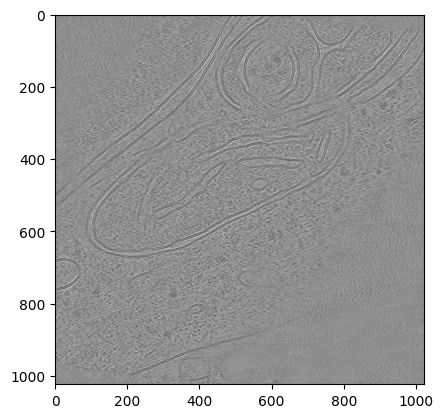

In [11]:
plt.imshow(data[280], cmap='gray')

In [115]:
for i in range(0, 500, 10):
    # images.append(np.array(data[i]))
    res = np.zeros((3, h, w))
    res[1] = data[i] 
    res[0] = np.mean(data[max(0, i-10):max(i, 1)], axis=0)
    res[2] = np.mean(data[i:i+10], axis=0)
    res -= np.min(res) 
    res /= np.max(res)
    np.save("/home/feity/cryoem/dataset/sjht0078_ori/%s_%i.npy"%("sjht", i), res)

In [163]:
a =np.load("/home/feity/cryoem/dataset/sjht0078_ori/sjht_280.npy")

In [164]:
# t = utils.getConstantTransform()
t = transforms.Compose([
    transforms.Resize((800, 800)),
    # transforms.ToTensor()
])
a = torch.tensor(a, dtype=torch.float32)
a = t(a)
a = a.unsqueeze(0)

In [165]:
a.shape

torch.Size([1, 3, 800, 800])

In [174]:
model = ConditionalDetrForObjectDetection.from_pretrained(
    "microsoft/conditional-detr-resnet-50",
    num_labels=14,
    ignore_mismatched_sizes=True,
)
# pars = torch.load("/home/feity/cryoem/checkpoints/conditional_detr_3_transform_3600/epoch=3296-validate_loss=2.04.ckpt")
pars = torch.load("/home/feity/cryoem/checkpoints/conditional_detr_without3_transform_3600/epoch=2655-validate_loss=1.24.ckpt")
model = modules.Detr(lr=1e-4, model=model, lr_backbone=1e-5, weight_decay=1e-4)
model.load_state_dict(pars["state_dict"])

Some weights of ConditionalDetrForObjectDetection were not initialized from the model checkpoint at microsoft/conditional-detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([14]) in the model instantiated
- class_labels_classifier.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([14, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_2894798/3733725718.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for

<All keys matched successfully>

In [166]:
a

tensor([[[[0.5585, 0.5692, 0.5719,  ..., 0.5530, 0.5659, 0.5764],
          [0.5490, 0.5579, 0.5733,  ..., 0.5560, 0.5620, 0.5672],
          [0.5381, 0.5507, 0.5742,  ..., 0.5625, 0.5636, 0.5563],
          ...,
          [0.5629, 0.5498, 0.5380,  ..., 0.5457, 0.5380, 0.5368],
          [0.5636, 0.5469, 0.5411,  ..., 0.5596, 0.5469, 0.5422],
          [0.5597, 0.5444, 0.5390,  ..., 0.5731, 0.5674, 0.5494]],

         [[0.5579, 0.5614, 0.6034,  ..., 0.5441, 0.5514, 0.5783],
          [0.5283, 0.5439, 0.5830,  ..., 0.5508, 0.5577, 0.5708],
          [0.5065, 0.5171, 0.5575,  ..., 0.5630, 0.5701, 0.5710],
          ...,
          [0.5589, 0.5633, 0.5436,  ..., 0.5657, 0.5595, 0.5519],
          [0.5609, 0.5493, 0.5456,  ..., 0.5616, 0.5490, 0.5474],
          [0.5271, 0.5412, 0.5339,  ..., 0.5600, 0.5517, 0.5665]],

         [[0.5501, 0.5651, 0.5909,  ..., 0.5511, 0.5495, 0.5544],
          [0.5407, 0.5403, 0.5524,  ..., 0.5542, 0.5610, 0.5665],
          [0.5332, 0.5196, 0.5198,  ..., 0

In [175]:
model = model.cpu()
with torch.no_grad():
    outputs = model(pixel_values = a, pixel_mask=torch.ones((1, 800, 800)))

In [176]:
importlib.reload(utils)
target_sizes = [(800, 800)]
results = utils.postSegmentationTreatment(outputs, 0.65, target_sizes, mask_threshold=None)
result = results[0]

In [ ]:
importlib.reload(utils)
target_sizes = [(800, 800)]
results = utils.postSegmentationTreatment(outputs, 0.65, target_sizes, mask_threshold=None)
result = results[0]

keep = utils.bbnms(0.01, result["boxes"], result["scores"], result["labels"])
for i in result:
    result[i] = result[i][keep]

In [178]:
result

{'scores': tensor([0.9441, 0.8952, 0.7273, 0.6613, 0.8863, 0.8237, 0.7881]),
 'labels': tensor([1, 1, 1, 1, 4, 4, 4]),
 'boxes': tensor([[405.7482, 620.9508, 534.2930, 750.4200],
         [639.7646, 613.6543, 790.1403, 781.0740],
         [ 43.5735, 275.2923, 527.6747, 479.1409],
         [725.1010, 413.9383, 771.9540, 432.5683],
         [160.4515, 226.2138, 204.9274, 242.8782],
         [217.5833, 363.5624, 269.8899, 389.6268],
         [294.0392,   3.6770, 338.6938,  21.1055]])}

In [38]:
def drawannotation(image, target):
    class_names = [str(i) for i in range(14)]
    int_colors = plt.cm.get_cmap("tab20", len(class_names))
    # import matplotlib.pyplot as plt
    from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

    if isinstance(image, torch.Tensor):
        image = image.numpy()
    if np.max(image) < 10:
        image -= np.min(image)
        image /= np.max(image)
        image = torch.tensor(image * 255).type(torch.uint8)

    if "masks" in target:
        annotated_tensor = draw_segmentation_masks(
            image=image,
            masks=target["masks"],
            alpha=0.3,
            colors=[int_colors(i) for i in [class_names.index(label) for label in target["names"]]]
        )
    else:
        annotated_tensor = image
        annotated_tensor = torch.tensor(annotated_tensor, dtype=torch.uint8)
    # Annotate the sample image with labels and bounding boxes
    # if "names" in target:
    annotated_tensor = draw_bounding_boxes(
        image=annotated_tensor,
        boxes=target["bboxes"],
        labels=target["names"] if "names" in target else target["labels"],
        font_size=30,
        colors=[class_names.index(label) for label in target["names"]]
    )
    res = annotated_tensor.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.moveaxis(res, 0, -1))

In [180]:
int_colors = plt.cm.get_cmap("tab20", 14)
int_colors(0)

/tmp/ipykernel_2894798/3909934053.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  int_colors = plt.cm.get_cmap("tab20", 14)


(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)

/tmp/ipykernel_2894798/3837870911.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  int_colors = plt.cm.get_cmap("tab20", len(class_names))
/tmp/ipykernel_2894798/3837870911.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  annotated_tensor = torch.tensor(annotated_tensor, dtype=torch.uint8)


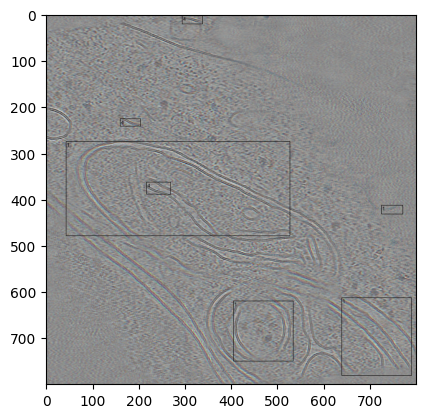

In [181]:
img = a[0]
t = utils.toTarget(result, img.shape[1:])
importlib.reload(utils)
drawannotation(img.cpu().numpy(), t)


In [182]:
t

{'labels': tensor([1, 1, 1, 1, 4, 4, 4]),
 'bboxes': BoundingBoxes([[405.7482, 620.9508, 534.2930, 750.4200],
                [639.7646, 613.6543, 790.1403, 781.0740],
                [ 43.5735, 275.2923, 527.6747, 479.1409],
                [725.1010, 413.9383, 771.9540, 432.5683],
                [160.4515, 226.2138, 204.9274, 242.8782],
                [217.5833, 363.5624, 269.8899, 389.6268],
                [294.0392,   3.6770, 338.6938,  21.1055]], format=BoundingBoxFormat.XYXY, canvas_size=torch.Size([800, 800])),
 'names': ['1', '1', '1', '1', '4', '4', '4']}

/home/feity/cryoem/utils.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  annotated_tensor = torch.tensor(annotated_tensor, dtype=torch.uint8)
/home/feity/anaconda3/envs/pytorch/lib/python3.12/site-packages/torchvision/utils.py:225: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


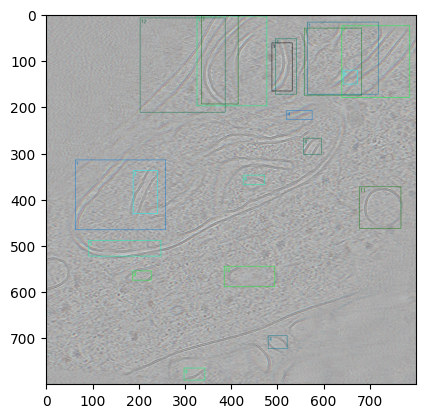

In [ ]:
img = a[0]
t = utils.toTarget(result, img.shape[1:])
importlib.reload(utils)
utils.drawannotation(img.cpu().numpy(), t)


In [2]:
path = "/home/feity/cryoem/checkpoints/deformable_train2"
with open(os.path.join(path, "config.json"), "r") as f:
    configs = json.load(f)

In [3]:
val_sets = {}
for i in configs["data"]["filter_class"]:
    val_sets[i] = modules.CocoDetection(
        configs["data"]["image_path"],
        configs["data"]["annotation_path_train"],
        is_npy=configs["data"]["is_npy"],
        transform=utils.getConstantTransform(),
        require_mask=configs["data"]["require_mask"][i],
        filter_class=configs["data"]["filter_class"][i],
        single_class=configs["data"]["single_class"][i],
        mark=i,
    )

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [4]:
data = val_sets["other"][10]

In [5]:
data["pixel_values"] = data["pixel_values"].unsqueeze(0).to(1)
data["pixel_mask"] = data["pixel_mask"].unsqueeze(0).to(1) 
data["mark"] = ["other"]
data["labels"] = [data["labels"]]

In [6]:
data["pixel_values"][0, 1]

tensor([[0.6618, 0.7426, 0.6975,  ..., 0.0000, 0.0000, 0.0000],
        [0.6474, 0.7551, 0.6581,  ..., 0.0000, 0.0000, 0.0000],
        [0.6313, 0.7102, 0.6131,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.5827, 0.4713, 0.4548,  ..., 0.0000, 0.0000, 0.0000],
        [0.5796, 0.5451, 0.5301,  ..., 0.0000, 0.0000, 0.0000],
        [0.5940, 0.5817, 0.5811,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:1')

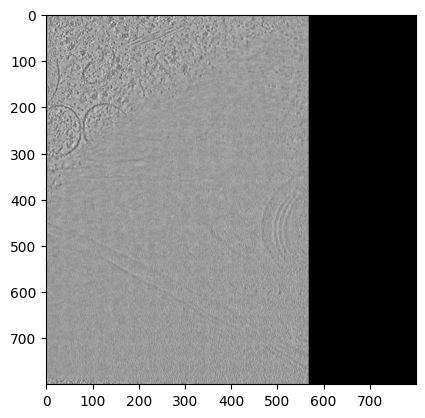

In [7]:
plt.imshow(data["pixel_values"][0, 1].cpu().numpy(), cmap='gray')

In [8]:
model = utils.getModel(configs)
# ckpt = torch.load(os.path.join(path, "last-v1.ckpt"))
# ckptsd = ckpt["state_dict"]
# for i in list(ckptsd.keys()):
#     if "gnn" in i:
#         del ckptsd[i]
# model.load_state_dict(ckptsd, strict=False)

Some weights of the model checkpoint at SenseTime/deformable-detr were not used when initializing DeformableDetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeformableDetrForObjectDetection wer

In [11]:
model.model["other"].model.query_position_embeddings.weight

Parameter containing:
tensor([[ 1.4726, -1.0093,  0.9364,  ..., -2.0795, -0.2501, -0.3768],
        [ 1.8853, -0.2575, -1.2879,  ..., -0.1762, -1.2504, -0.9542],
        [-1.8424, -0.7747,  0.4702,  ...,  0.2137, -0.2123, -0.8794],
        ...,
        [ 0.4291,  1.9414,  0.2387,  ..., -0.8920,  0.8204, -0.2714],
        [-0.0841,  1.0365, -0.9128,  ..., -1.0423, -0.8059,  0.1353],
        [ 0.4590, -0.2123, -0.1818,  ...,  1.0479,  0.5767, -0.4736]],
       device='cuda:1', requires_grad=True)

In [14]:
model.model["other"].model.query_position_embeddings.weight

Parameter containing:
tensor([[ 1.4721, -1.0090,  0.9362,  ..., -2.0796, -0.2502, -0.3768],
        [ 1.8854, -0.2576, -1.2878,  ..., -0.1762, -1.2505, -0.9541],
        [-1.8421, -0.7749,  0.4700,  ...,  0.2140, -0.2121, -0.8796],
        ...,
        [ 0.4297,  1.9406,  0.2392,  ..., -0.8918,  0.8205, -0.2712],
        [-0.0844,  1.0368, -0.9131,  ..., -1.0424, -0.8061,  0.1356],
        [ 0.4587, -0.2124, -0.1814,  ...,  1.0478,  0.5766, -0.4737]],
       device='cuda:1', requires_grad=True)

In [12]:
losses = [] 
model = model.to(1)
model.lr = 1e-3
model.lr_backbone = 0.0
model.lr_encoder = 0.0
opt = model.configure_optimizers()

In [13]:

for i in range(1000):
    model.train()
    loss, loss_dict = model.common_step(data)
    opt.zero_grad()
    loss.backward()
    opt.step()
    losses.append(loss.item())
    if i % 10 == 0:
        print(i, loss_dict)

0 {'loss_ce': tensor(1.1127, device='cuda:1', grad_fn=<MulBackward0>), 'loss_bbox': tensor(0.1225, device='cuda:1', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.9767, device='cuda:1', grad_fn=<DivBackward0>), 'cardinality_error': tensor(81., device='cuda:1')}
10 {'loss_ce': tensor(0.9133, device='cuda:1', grad_fn=<MulBackward0>), 'loss_bbox': tensor(0.1127, device='cuda:1', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.8204, device='cuda:1', grad_fn=<DivBackward0>), 'cardinality_error': tensor(81., device='cuda:1')}
20 {'loss_ce': tensor(0.7104, device='cuda:1', grad_fn=<MulBackward0>), 'loss_bbox': tensor(0.0909, device='cuda:1', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.7072, device='cuda:1', grad_fn=<DivBackward0>), 'cardinality_error': tensor(81., device='cuda:1')}
30 {'loss_ce': tensor(0.5352, device='cuda:1', grad_fn=<MulBackward0>), 'loss_bbox': tensor(0.0828, device='cuda:1', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.7088, device='cuda:1', grad_fn=<DivBackward0>), 

KeyboardInterrupt: 

In [26]:
output = model(pixel_values=data["pixel_values"].unsqueeze(0).float(), pixel_mask=data["pixel_mask"].unsqueeze(0).float())
o = {} 
o["pred_boxes"] = output["other"]["pred_boxes"]
o["logits"] = output["other"]["logits"]


In [36]:
importlib.reload(utils)
target_sizes = [(800, 800)]
results = utils.postSegmentationTreatment(output["ribo"], 0.35, target_sizes, mask_threshold=None)
result = results[0]

keep = utils.bbnms(0.01, result["boxes"], result["scores"], result["labels"])
for i in result:
    result[i] = result[i][keep]

In [56]:
for i, j in model.named_parameters():
    print(i)

model.other.model.level_embed
model.other.model.backbone.conv_encoder.model.conv1.weight
model.other.model.backbone.conv_encoder.model.layer1.0.conv1.weight
model.other.model.backbone.conv_encoder.model.layer1.0.conv2.weight
model.other.model.backbone.conv_encoder.model.layer1.0.conv3.weight
model.other.model.backbone.conv_encoder.model.layer1.0.downsample.0.weight
model.other.model.backbone.conv_encoder.model.layer1.1.conv1.weight
model.other.model.backbone.conv_encoder.model.layer1.1.conv2.weight
model.other.model.backbone.conv_encoder.model.layer1.1.conv3.weight
model.other.model.backbone.conv_encoder.model.layer1.2.conv1.weight
model.other.model.backbone.conv_encoder.model.layer1.2.conv2.weight
model.other.model.backbone.conv_encoder.model.layer1.2.conv3.weight
model.other.model.backbone.conv_encoder.model.layer2.0.conv1.weight
model.other.model.backbone.conv_encoder.model.layer2.0.conv2.weight
model.other.model.backbone.conv_encoder.model.layer2.0.conv3.weight
model.other.model.ba

/tmp/ipykernel_35292/2309018418.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  int_colors = plt.cm.get_cmap("tab20", len(class_names))
/tmp/ipykernel_35292/2309018418.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  annotated_tensor = torch.tensor(annotated_tensor, dtype=torch.uint8)
/home/feity/anaconda3/envs/pytorch/lib/python3.12/site-packages/torchvision/utils.py:225: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


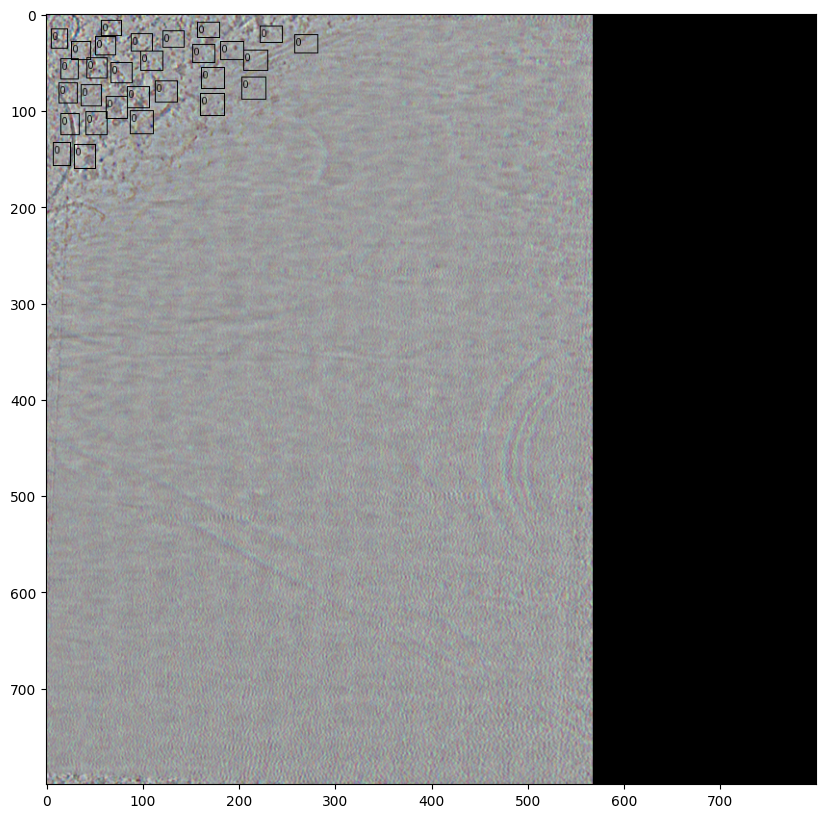

In [39]:
img = data["pixel_values"]
t = utils.toTarget(result, img.shape[1:])
importlib.reload(utils)
drawannotation(img.cpu().numpy(), t)

In [54]:
a = torch.randn((2,3,4))
b = torch.randn((2,4,4))
a.shape == b.shape

False